In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        #{'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['t1'],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_t1_0_0_basal_seg_data_norm_e_e_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 1)
(1079604, 3)
validation
(190293, 1)
(190293, 3)
test
(137379, 1)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1)]               0         


 dense (Dense)               (None, 1024)              2048      


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 691459 (2.64 MB)


Trainable params: 691459 (2.64 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:00 - loss: 1.3459 - STD: 0.2323 - MAE: 0.4458

  9/108 [=>............................] - ETA: 0s - loss: 1.1593 - STD: 0.0942 - MAE: 0.4444  

 17/108 [===>..........................] - ETA: 0s - loss: 1.1368 - STD: 0.0750 - MAE: 0.4443

 25/108 [=====>........................] - ETA: 0s - loss: 1.1260 - STD: 0.0625 - MAE: 0.4442

 33/108 [========>.....................] - ETA: 0s - loss: 1.1188 - STD: 0.0532 - MAE: 0.4440

 41/108 [==========>...................] - ETA: 0s - loss: 1.1132 - STD: 0.0463 - MAE: 0.4436

 50/108 [============>.................] - ETA: 0s - loss: 1.1073 - STD: 0.0434 - MAE: 0.4429

 54/108 [==============>...............] - ETA: 0s - loss: 1.1045 - STD: 0.0437 - MAE: 0.4423

 62/108 [================>.............] - ETA: 0s - loss: 1.0991 - STD: 0.0468 - MAE: 0.4409

 70/108 [==================>...........] - ETA: 0s - loss: 1.0942 - STD: 0.0515 - MAE: 0.4394

 78/108 [====================>.........] - ETA: 0s - loss: 1.0900 - STD: 0.0554 - MAE: 0.4381

 86/108 [======================>.......] - ETA: 0s - loss: 1.0867 - STD: 0.0590 - MAE: 0.4370

 94/108 [=========================>....] - ETA: 0s - loss: 1.0836 - STD: 0.0623 - MAE: 0.4359

102/108 [===========================>..] - ETA: 0s - loss: 1.0811 - STD: 0.0650 - MAE: 0.4351

108/108 [==============================] - 3s 18ms/step - loss: 1.0794 - STD: 0.0668 - MAE: 0.4345 - val_loss: 1.0630 - val_STD: 0.0969 - val_MAE: 0.4276


Epoch 2/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0504 - STD: 0.0946 - MAE: 0.4253

  9/108 [=>............................] - ETA: 0s - loss: 1.0488 - STD: 0.0988 - MAE: 0.4241

 17/108 [===>..........................] - ETA: 0s - loss: 1.0483 - STD: 0.0999 - MAE: 0.4238

 25/108 [=====>........................] - ETA: 0s - loss: 1.0487 - STD: 0.1000 - MAE: 0.4239

 33/108 [========>.....................] - ETA: 0s - loss: 1.0486 - STD: 0.0998 - MAE: 0.4239

 41/108 [==========>...................] - ETA: 0s - loss: 1.0483 - STD: 0.1002 - MAE: 0.4238

 49/108 [============>.................] - ETA: 0s - loss: 1.0482 - STD: 0.1002 - MAE: 0.4238

 57/108 [==============>...............] - ETA: 0s - loss: 1.0480 - STD: 0.1007 - MAE: 0.4236

 65/108 [=================>............] - ETA: 0s - loss: 1.0480 - STD: 0.1008 - MAE: 0.4236

 73/108 [===================>..........] - ETA: 0s - loss: 1.0481 - STD: 0.1008 - MAE: 0.4236

 81/108 [=====================>........] - ETA: 0s - loss: 1.0479 - STD: 0.1012 - MAE: 0.4235

 89/108 [=======================>......] - ETA: 0s - loss: 1.0479 - STD: 0.1012 - MAE: 0.4235

 97/108 [=========================>....] - ETA: 0s - loss: 1.0478 - STD: 0.1015 - MAE: 0.4234

105/108 [============================>.] - ETA: 0s - loss: 1.0479 - STD: 0.1015 - MAE: 0.4234

108/108 [==============================] - 1s 8ms/step - loss: 1.0479 - STD: 0.1015 - MAE: 0.4234 - val_loss: 1.0541 - val_STD: 0.0883 - val_MAE: 0.4270


Epoch 3/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0493 - STD: 0.1061 - MAE: 0.4227

  9/108 [=>............................] - ETA: 0s - loss: 1.0488 - STD: 0.1016 - MAE: 0.4236

 17/108 [===>..........................] - ETA: 0s - loss: 1.0485 - STD: 0.1029 - MAE: 0.4233

 25/108 [=====>........................] - ETA: 0s - loss: 1.0484 - STD: 0.1026 - MAE: 0.4234

 33/108 [========>.....................] - ETA: 0s - loss: 1.0477 - STD: 0.1034 - MAE: 0.4230

 41/108 [==========>...................] - ETA: 0s - loss: 1.0475 - STD: 0.1032 - MAE: 0.4230

 49/108 [============>.................] - ETA: 0s - loss: 1.0475 - STD: 0.1034 - MAE: 0.4230

 57/108 [==============>...............] - ETA: 0s - loss: 1.0476 - STD: 0.1032 - MAE: 0.4231

 65/108 [=================>............] - ETA: 0s - loss: 1.0474 - STD: 0.1035 - MAE: 0.4229

 73/108 [===================>..........] - ETA: 0s - loss: 1.0473 - STD: 0.1036 - MAE: 0.4229

 81/108 [=====================>........] - ETA: 0s - loss: 1.0476 - STD: 0.1036 - MAE: 0.4230

 89/108 [=======================>......] - ETA: 0s - loss: 1.0476 - STD: 0.1037 - MAE: 0.4229

 97/108 [=========================>....] - ETA: 0s - loss: 1.0477 - STD: 0.1037 - MAE: 0.4229

105/108 [============================>.] - ETA: 0s - loss: 1.0477 - STD: 0.1037 - MAE: 0.4229

108/108 [==============================] - 1s 7ms/step - loss: 1.0477 - STD: 0.1038 - MAE: 0.4229 - val_loss: 1.0646 - val_STD: 0.0959 - val_MAE: 0.4285


Epoch 4/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0457 - STD: 0.0993 - MAE: 0.4235

  9/108 [=>............................] - ETA: 0s - loss: 1.0456 - STD: 0.1044 - MAE: 0.4224

 17/108 [===>..........................] - ETA: 0s - loss: 1.0471 - STD: 0.1038 - MAE: 0.4228

 25/108 [=====>........................] - ETA: 0s - loss: 1.0470 - STD: 0.1045 - MAE: 0.4226

 33/108 [========>.....................] - ETA: 0s - loss: 1.0470 - STD: 0.1040 - MAE: 0.4227

 40/108 [==========>...................] - ETA: 0s - loss: 1.0469 - STD: 0.1045 - MAE: 0.4226

 48/108 [============>.................] - ETA: 0s - loss: 1.0471 - STD: 0.1042 - MAE: 0.4227

 56/108 [==============>...............] - ETA: 0s - loss: 1.0470 - STD: 0.1044 - MAE: 0.4227

 64/108 [================>.............] - ETA: 0s - loss: 1.0469 - STD: 0.1043 - MAE: 0.4227

 72/108 [===================>..........] - ETA: 0s - loss: 1.0470 - STD: 0.1043 - MAE: 0.4227

 80/108 [=====================>........] - ETA: 0s - loss: 1.0471 - STD: 0.1042 - MAE: 0.4227

 88/108 [=======================>......] - ETA: 0s - loss: 1.0475 - STD: 0.1041 - MAE: 0.4228

 96/108 [=========================>....] - ETA: 0s - loss: 1.0476 - STD: 0.1039 - MAE: 0.4229

104/108 [===========================>..] - ETA: 0s - loss: 1.0474 - STD: 0.1041 - MAE: 0.4228

108/108 [==============================] - 1s 7ms/step - loss: 1.0474 - STD: 0.1040 - MAE: 0.4228 - val_loss: 1.0610 - val_STD: 0.0919 - val_MAE: 0.4284


Epoch 5/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0393 - STD: 0.1040 - MAE: 0.4212

  9/108 [=>............................] - ETA: 0s - loss: 1.0475 - STD: 0.1045 - MAE: 0.4228

 17/108 [===>..........................] - ETA: 0s - loss: 1.0471 - STD: 0.1040 - MAE: 0.4228

 26/108 [======>.......................] - ETA: 0s - loss: 1.0467 - STD: 0.1046 - MAE: 0.4226

 34/108 [========>.....................] - ETA: 0s - loss: 1.0465 - STD: 0.1047 - MAE: 0.4225

 42/108 [==========>...................] - ETA: 0s - loss: 1.0461 - STD: 0.1052 - MAE: 0.4223

 50/108 [============>.................] - ETA: 0s - loss: 1.0466 - STD: 0.1049 - MAE: 0.4225

 57/108 [==============>...............] - ETA: 0s - loss: 1.0465 - STD: 0.1047 - MAE: 0.4225

 64/108 [================>.............] - ETA: 0s - loss: 1.0467 - STD: 0.1046 - MAE: 0.4226

 72/108 [===================>..........] - ETA: 0s - loss: 1.0468 - STD: 0.1044 - MAE: 0.4226

 80/108 [=====================>........] - ETA: 0s - loss: 1.0468 - STD: 0.1046 - MAE: 0.4226

 88/108 [=======================>......] - ETA: 0s - loss: 1.0466 - STD: 0.1046 - MAE: 0.4225

 96/108 [=========================>....] - ETA: 0s - loss: 1.0464 - STD: 0.1048 - MAE: 0.4225

105/108 [============================>.] - ETA: 0s - loss: 1.0466 - STD: 0.1046 - MAE: 0.4226

108/108 [==============================] - 1s 7ms/step - loss: 1.0466 - STD: 0.1047 - MAE: 0.4225 - val_loss: 1.0677 - val_STD: 0.0979 - val_MAE: 0.4292


Epoch 6/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0469 - STD: 0.1025 - MAE: 0.4230

  9/108 [=>............................] - ETA: 0s - loss: 1.0476 - STD: 0.1040 - MAE: 0.4229

 17/108 [===>..........................] - ETA: 0s - loss: 1.0466 - STD: 0.1047 - MAE: 0.4225

 25/108 [=====>........................] - ETA: 0s - loss: 1.0465 - STD: 0.1046 - MAE: 0.4225

 33/108 [========>.....................] - ETA: 0s - loss: 1.0465 - STD: 0.1044 - MAE: 0.4226

 41/108 [==========>...................] - ETA: 0s - loss: 1.0464 - STD: 0.1048 - MAE: 0.4225

 49/108 [============>.................] - ETA: 0s - loss: 1.0468 - STD: 0.1048 - MAE: 0.4226

 57/108 [==============>...............] - ETA: 0s - loss: 1.0468 - STD: 0.1045 - MAE: 0.4226

 65/108 [=================>............] - ETA: 0s - loss: 1.0466 - STD: 0.1047 - MAE: 0.4225

 73/108 [===================>..........] - ETA: 0s - loss: 1.0465 - STD: 0.1048 - MAE: 0.4225

 81/108 [=====================>........] - ETA: 0s - loss: 1.0465 - STD: 0.1049 - MAE: 0.4225

 89/108 [=======================>......] - ETA: 0s - loss: 1.0466 - STD: 0.1048 - MAE: 0.4225

 97/108 [=========================>....] - ETA: 0s - loss: 1.0467 - STD: 0.1048 - MAE: 0.4225

105/108 [============================>.] - ETA: 0s - loss: 1.0465 - STD: 0.1049 - MAE: 0.4225

108/108 [==============================] - 1s 7ms/step - loss: 1.0466 - STD: 0.1049 - MAE: 0.4225 - val_loss: 1.0616 - val_STD: 0.0915 - val_MAE: 0.4285


Epoch 7/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0495 - STD: 0.1029 - MAE: 0.4237

  9/108 [=>............................] - ETA: 0s - loss: 1.0479 - STD: 0.1032 - MAE: 0.4231

 17/108 [===>..........................] - ETA: 0s - loss: 1.0472 - STD: 0.1034 - MAE: 0.4229

 25/108 [=====>........................] - ETA: 0s - loss: 1.0475 - STD: 0.1042 - MAE: 0.4228

 33/108 [========>.....................] - ETA: 0s - loss: 1.0469 - STD: 0.1042 - MAE: 0.4227

 41/108 [==========>...................] - ETA: 0s - loss: 1.0468 - STD: 0.1047 - MAE: 0.4226

 49/108 [============>.................] - ETA: 0s - loss: 1.0463 - STD: 0.1050 - MAE: 0.4224

 57/108 [==============>...............] - ETA: 0s - loss: 1.0462 - STD: 0.1052 - MAE: 0.4224

 65/108 [=================>............] - ETA: 0s - loss: 1.0463 - STD: 0.1052 - MAE: 0.4224

 73/108 [===================>..........] - ETA: 0s - loss: 1.0464 - STD: 0.1049 - MAE: 0.4224

 81/108 [=====================>........] - ETA: 0s - loss: 1.0464 - STD: 0.1052 - MAE: 0.4224

 89/108 [=======================>......] - ETA: 0s - loss: 1.0464 - STD: 0.1052 - MAE: 0.4224

 97/108 [=========================>....] - ETA: 0s - loss: 1.0464 - STD: 0.1050 - MAE: 0.4224

105/108 [============================>.] - ETA: 0s - loss: 1.0465 - STD: 0.1051 - MAE: 0.4224

108/108 [==============================] - 1s 7ms/step - loss: 1.0465 - STD: 0.1050 - MAE: 0.4224 - val_loss: 1.0599 - val_STD: 0.0873 - val_MAE: 0.4291


Epoch 8/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0441 - STD: 0.1044 - MAE: 0.4222

  9/108 [=>............................] - ETA: 0s - loss: 1.0441 - STD: 0.1074 - MAE: 0.4215

 17/108 [===>..........................] - ETA: 0s - loss: 1.0447 - STD: 0.1059 - MAE: 0.4219

 25/108 [=====>........................] - ETA: 0s - loss: 1.0455 - STD: 0.1062 - MAE: 0.4220

 33/108 [========>.....................] - ETA: 0s - loss: 1.0458 - STD: 0.1056 - MAE: 0.4222

 41/108 [==========>...................] - ETA: 0s - loss: 1.0460 - STD: 0.1056 - MAE: 0.4222

 49/108 [============>.................] - ETA: 0s - loss: 1.0461 - STD: 0.1053 - MAE: 0.4223

 57/108 [==============>...............] - ETA: 0s - loss: 1.0462 - STD: 0.1052 - MAE: 0.4224

 66/108 [=================>............] - ETA: 0s - loss: 1.0463 - STD: 0.1051 - MAE: 0.4224

 74/108 [===================>..........] - ETA: 0s - loss: 1.0463 - STD: 0.1051 - MAE: 0.4224

 82/108 [=====================>........] - ETA: 0s - loss: 1.0461 - STD: 0.1054 - MAE: 0.4223

 90/108 [========================>.....] - ETA: 0s - loss: 1.0461 - STD: 0.1052 - MAE: 0.4223

 98/108 [==========================>...] - ETA: 0s - loss: 1.0461 - STD: 0.1054 - MAE: 0.4223

106/108 [============================>.] - ETA: 0s - loss: 1.0460 - STD: 0.1055 - MAE: 0.4222

108/108 [==============================] - 1s 7ms/step - loss: 1.0459 - STD: 0.1055 - MAE: 0.4222 - val_loss: 1.0654 - val_STD: 0.0961 - val_MAE: 0.4290


Epoch 9/10000


  1/108 [..............................] - ETA: 2s - loss: 1.0453 - STD: 0.1069 - MAE: 0.4218

  9/108 [=>............................] - ETA: 0s - loss: 1.0457 - STD: 0.1046 - MAE: 0.4224

 17/108 [===>..........................] - ETA: 0s - loss: 1.0447 - STD: 0.1067 - MAE: 0.4217

 25/108 [=====>........................] - ETA: 0s - loss: 1.0454 - STD: 0.1053 - MAE: 0.4221

 33/108 [========>.....................] - ETA: 0s - loss: 1.0455 - STD: 0.1056 - MAE: 0.4221

 41/108 [==========>...................] - ETA: 0s - loss: 1.0451 - STD: 0.1060 - MAE: 0.4219

 49/108 [============>.................] - ETA: 0s - loss: 1.0452 - STD: 0.1059 - MAE: 0.4220

 57/108 [==============>...............] - ETA: 0s - loss: 1.0455 - STD: 0.1056 - MAE: 0.4221

 65/108 [=================>............] - ETA: 0s - loss: 1.0453 - STD: 0.1058 - MAE: 0.4220

 73/108 [===================>..........] - ETA: 0s - loss: 1.0452 - STD: 0.1058 - MAE: 0.4220

 81/108 [=====================>........] - ETA: 0s - loss: 1.0452 - STD: 0.1060 - MAE: 0.4220

 89/108 [=======================>......] - ETA: 0s - loss: 1.0453 - STD: 0.1058 - MAE: 0.4220

 97/108 [=========================>....] - ETA: 0s - loss: 1.0454 - STD: 0.1057 - MAE: 0.4221

105/108 [============================>.] - ETA: 0s - loss: 1.0454 - STD: 0.1058 - MAE: 0.4220

108/108 [==============================] - 1s 7ms/step - loss: 1.0454 - STD: 0.1057 - MAE: 0.4221 - val_loss: 1.0675 - val_STD: 0.0939 - val_MAE: 0.4297


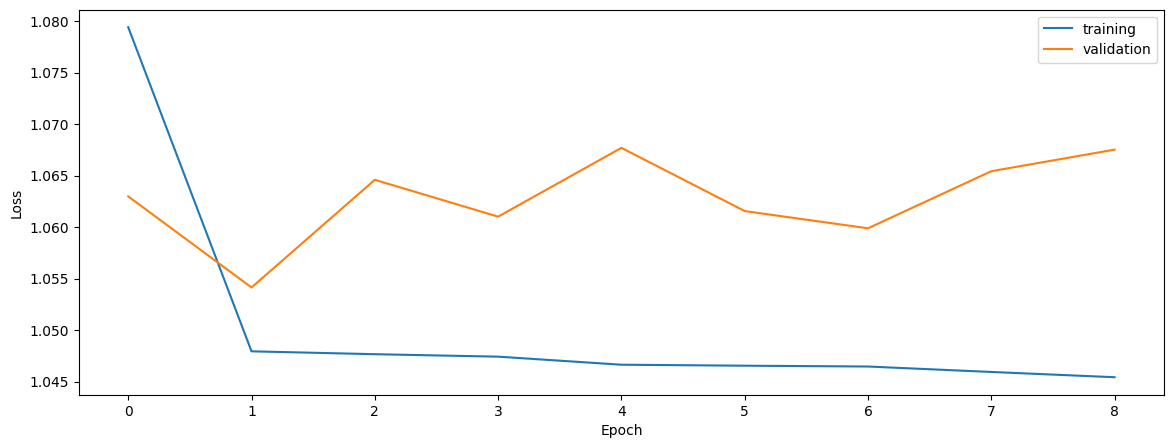

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

print('train')
print(getAccuracy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuracy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuracy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.41592843301803256


0.41238511138087053


0.4533735141469948


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuracy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuracy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.41394411880854237


0.5716388491764726


0.558504235915004


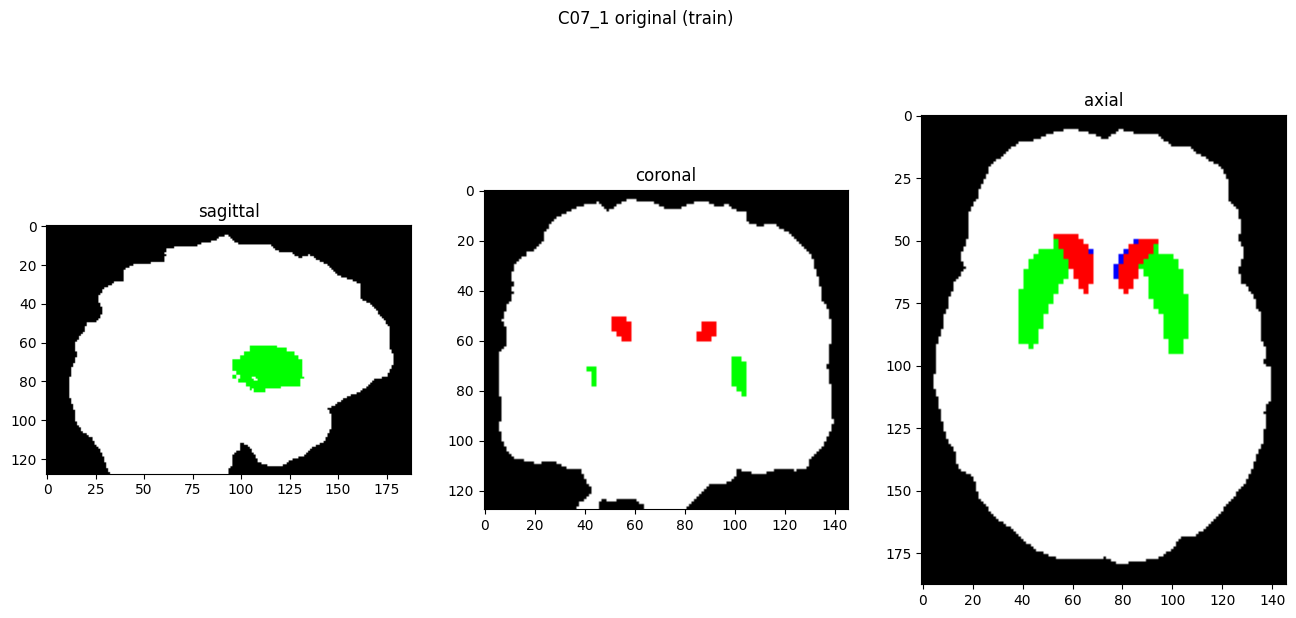

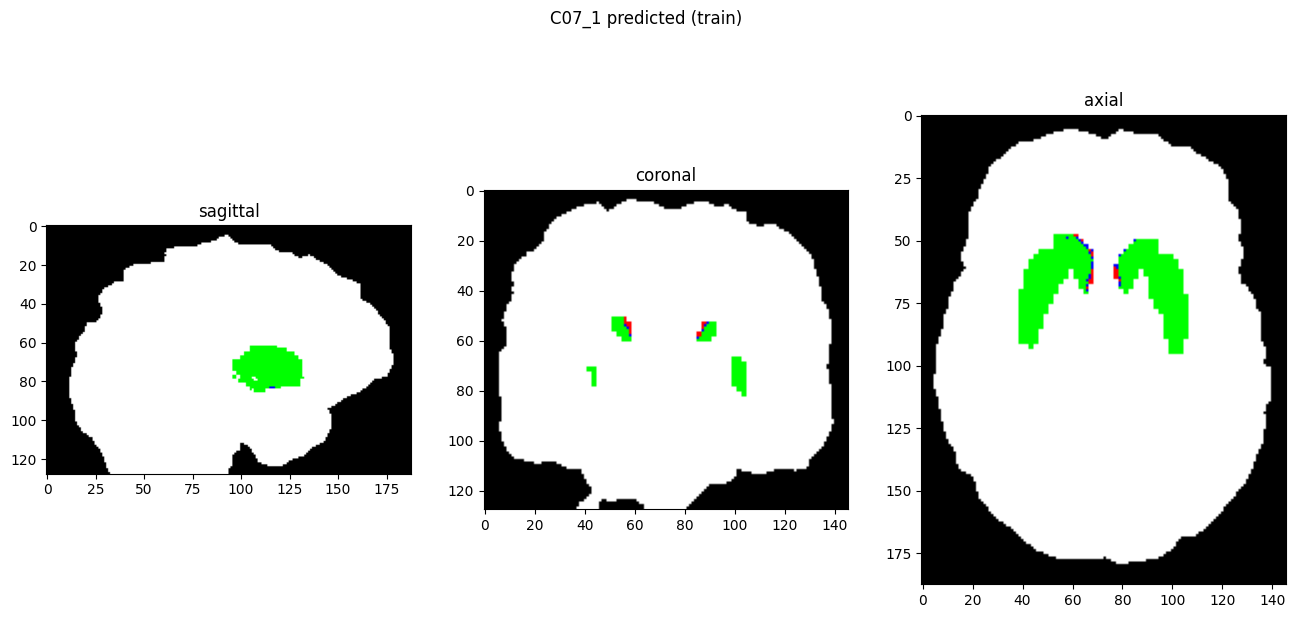

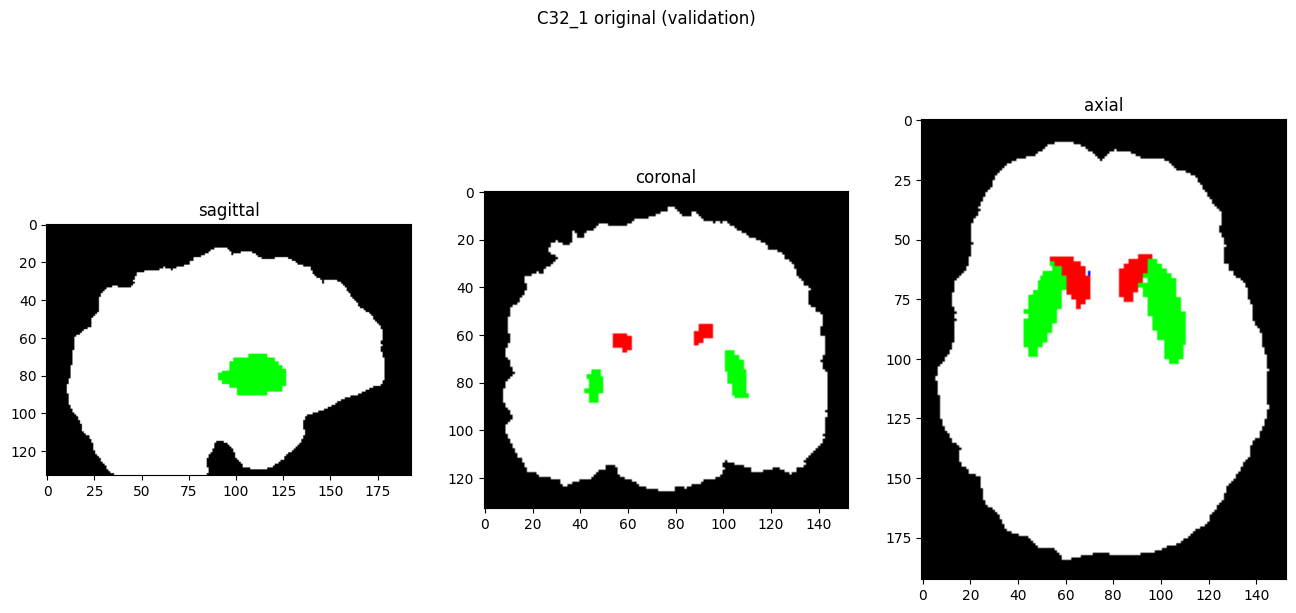

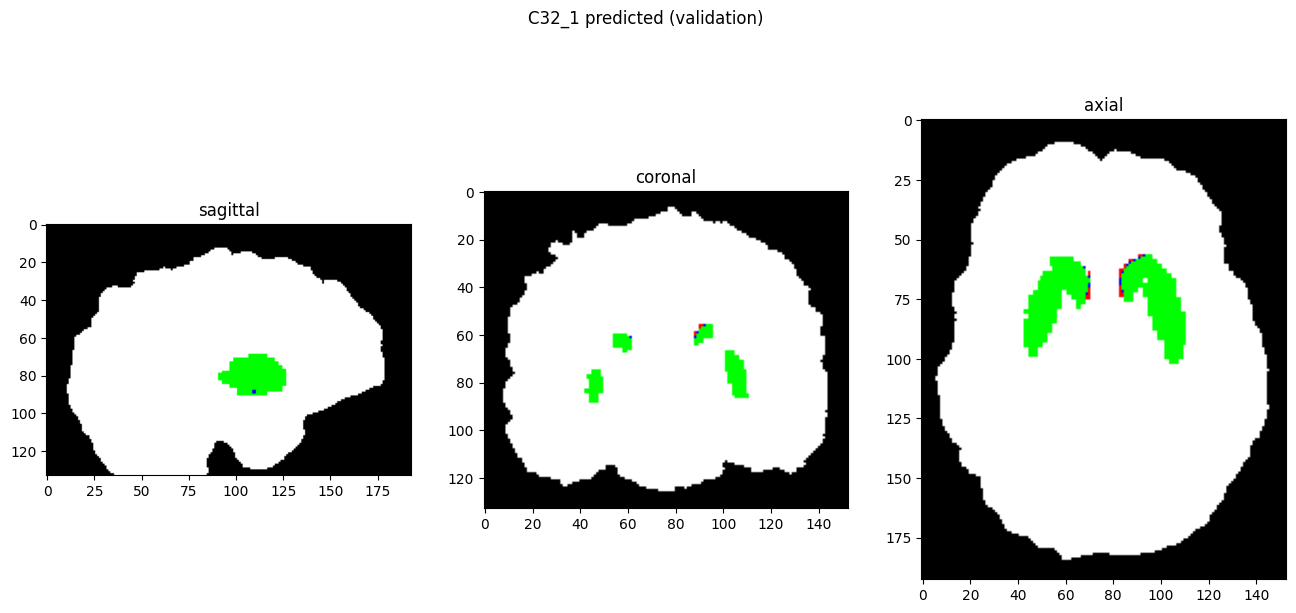

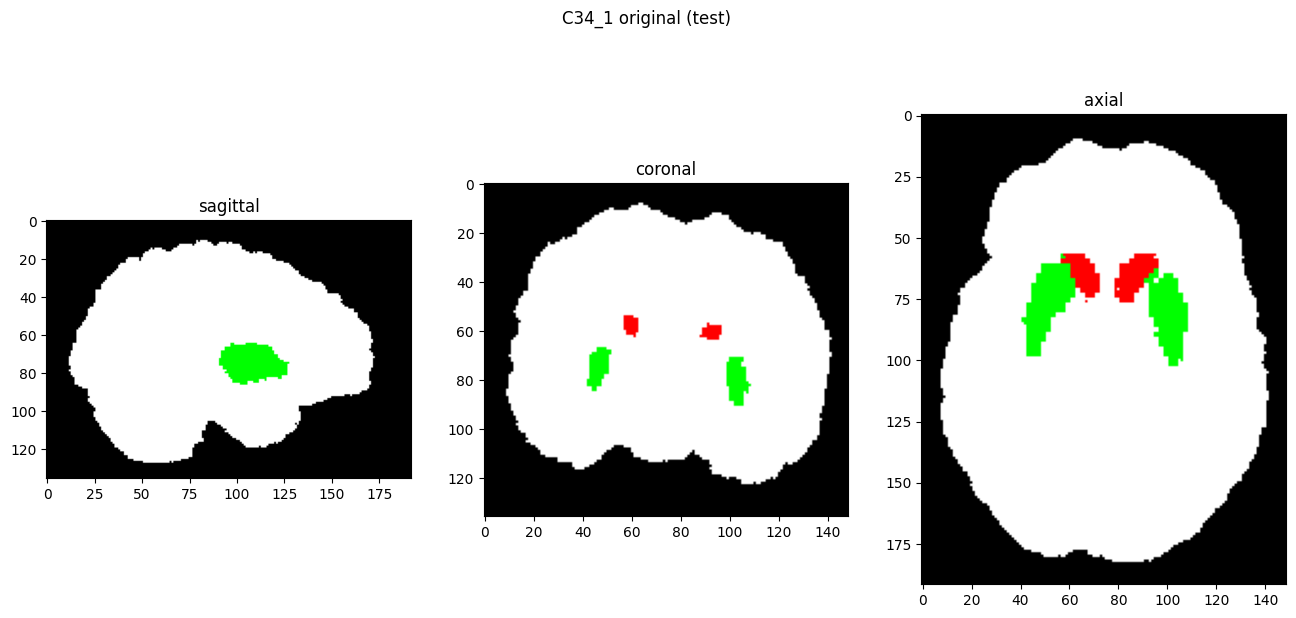

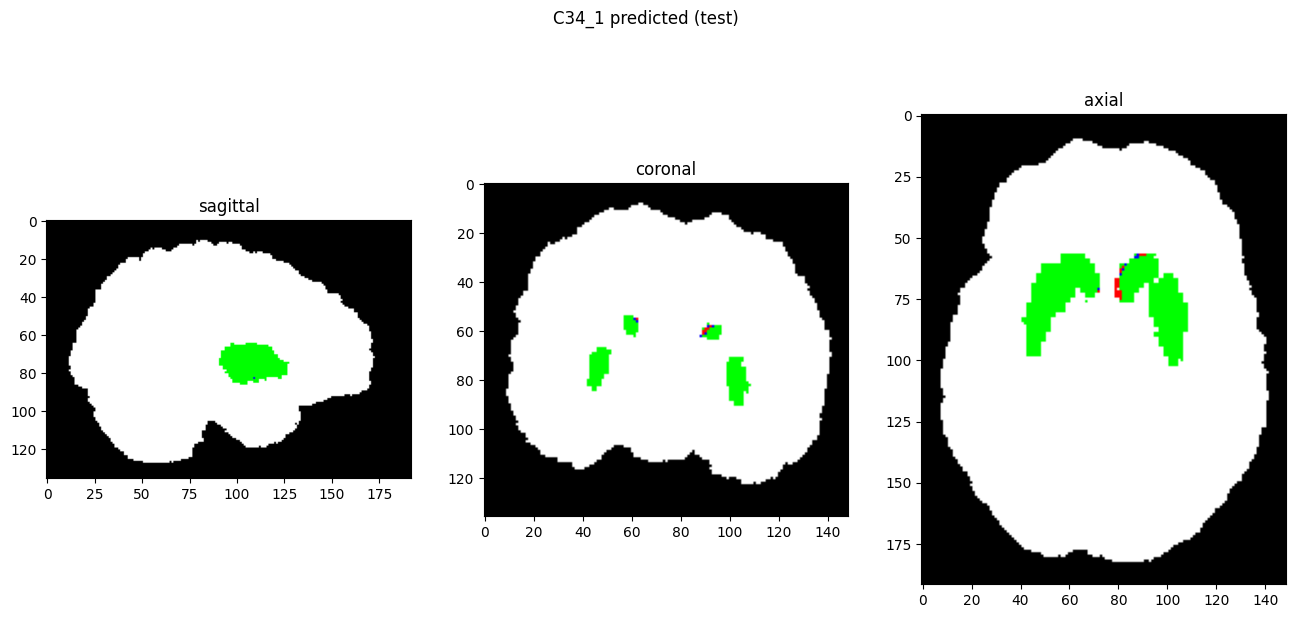

In [9]:
showResults(model, gen, threshold=0)